**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/target-encoding).**

---


# Introduction #

In this exercise, you'll apply target encoding to features in the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset.

Run this cell to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex6 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("../input/fe-course-data/ames.csv")

-------------------------------------------------------------------------------

First you'll need to choose which features you want to apply a target encoding to. **Categorical features** with a **large number** of *categories* are often good candidates. Run this cell to see **_how many categories_** each **_categorical feature_** in the *Ames* dataset has.

In [2]:
df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       5
SaleType         10
SaleCondition     6
dtype: int64

We talked about how the M-estimate encoding uses smoothing to improve estimates for rare categories. To see how many times a category occurs in the dataset, you can use the `value_counts` method. This cell shows the counts for `SaleType`, but you might want to consider others as well.

In [3]:
df["SaleType"].value_counts()

SaleType
WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64

In [4]:
# My
df["Neighborhood"].value_counts()

Neighborhood
North_Ames                                 443
College_Creek                              267
Old_Town                                   239
Edwards                                    194
Somerset                                   182
Northridge_Heights                         166
Gilbert                                    165
Sawyer                                     151
Northwest_Ames                             131
Sawyer_West                                125
Mitchell                                   114
Brookside                                  108
Crawford                                   103
Iowa_DOT_and_Rail_Road                      93
Timberland                                  72
Northridge                                  71
Stone_Brook                                 51
South_and_West_of_Iowa_State_University     48
Clear_Creek                                 44
Meadow_Village                              37
Briardale                                   30


# 1) Choose Features for Encoding

Which features did you identify for target encoding? After you've thought about your answer, run the next cell for some discussion.

In [5]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

 The `Neighborhood` feature looks promising. It has the most categories of any feature, and several categories are rare. Others that could be worth considering are `SaleType`, `MSSubClass`, `Exterior1st`, `Exterior2nd`. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.

*Характеристиката `Neighborhood` изглежда обещаващо. Тя има най-много категории от всяка и няколко категории са редки. Други, които може да си струва да обмислите, са `SaleType`, `MSSubClass`, `Exterior1st`, `Exterior2nd`Neighborhood. Всъщност почти всяка от номиналните характеристики би си струвала да се опита поради преобладаването на редки категории.
*

-------------------------------------------------------------------------------

Now you'll apply a target encoding to your choice of feature. As we discussed in the tutorial, to avoid overfitting, we need to fit the encoder on data heldout from the training set. Run this cell to create the encoding and training splits:

*Сега ще приложите целево кодиране към избраната от вас характеристика. Както обсъдихме в урока, за да избегнем свръхнастройването(overfitting), трябва да напаснем енкодера върху задържани данни от набора за обучение. Стартирайте тази клетка, за да създадете разделянето на кодиране и обучение:*

In [8]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
print(f"X_pretrain.shape before .pop(): {X_pretrain.shape}")
y_train = X_pretrain.pop("SalePrice")
print(f"X_pretrain.shape after .pop(): {X_pretrain.shape}")

X_pretrain.shape before .pop(): (2344, 79)
X_pretrain.shape after .pop(): (2344, 78)


In [9]:
# My
df.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea          float64
Street            object
                  ...   
MoSold             int64
YearSold           int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 79, dtype: object

In [10]:
# My
X_encode

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition
2216,One_and_Half_Story_Finished_All_Ages,Residential_Low_Density,0.0,11275.0,Pave,No_Alley_Access,Slightly_Irregular,HLS,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,3,2007,WD,Normal
836,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,65.0,9757.0,Pave,No_Alley_Access,Regular,Low,AllPub,Inside,...,92.0,0.0,No_Pool,No_Fence,NaN,0.0,10,2009,WD,Normal
2396,Two_Story_1946_and_Newer,Residential_Low_Density,86.0,11065.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,10,2006,New,Partial
1962,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,70.0,7000.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Wood_Wire,NaN,0.0,4,2007,WD,Family
305,One_and_Half_Story_Finished_All_Ages,C_all,66.0,8712.0,Pave,Paved,Regular,HLS,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,1,2010,WD,Abnorml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352,Split_Foyer,Residential_Low_Density,0.0,9927.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,7,2006,WD,Normal
2027,One_and_Half_Story_Finished_All_Ages,Residential_Medium_Density,60.0,8520.0,Pave,Gravel,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Good_Wood,NaN,0.0,8,2007,CWD,Family
867,Two_Story_1946_and_Newer,Residential_Low_Density,70.0,8749.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,11,2009,WD,Normal
2590,One_Story_1945_and_Older,Residential_Low_Density,118.0,21299.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,12,2006,COD,Abnorml


In [12]:
# My
y_encode, df.shape, X_pretrain.shape, y_train

(2216    220000
 836     143000
 2396    281000
 1962    135000
 305     102776
          ...  
 2352    172000
 2027    136000
 867     198500
 2590    167000
 1418    262280
 Name: SalePrice, Length: 586, dtype: int64,
 (2930, 79),
 (2344, 78),
 0       215000
 1       105000
 2       172000
 3       244000
 4       189900
          ...  
 2924    131000
 2925    142500
 2926    131000
 2927    132000
 2929    188000
 Name: SalePrice, Length: 2344, dtype: int64)

In [13]:
# My check
X_pretrain.shape[0] / df.shape[0]

0.8

# 2) Apply M-Estimate Encoding / Прилагане на кодиране M-Estimate(М-оценка)

Apply a target encoding to your choice of categorical features. 

Also choose a value for the smoothing parameter `m` (*any value is okay for a correct answer*).

In [15]:
# YOUR CODE HERE: Create the MEstimateEncoder
# Choose a set of features to encode and a value for m
encoder = MEstimateEncoder(cols = ["Neighborhood","SaleType", "Exterior2nd"], m = 2)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)


# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [12]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

If you'd like to see how the encoded feature compares to the target, you can run this cell:

In [42]:
# My
encoder_2 = MEstimateEncoder(
    cols = ["Neighborhood", "SaleType","MSSubClass", "Exterior1st", "Exterior2nd"],
    m = 72
)
# Fit the encoder on the encoding split
encoder_2.fit(X_encode, y_encode)

# Encode the training split
X_train_2 = encoder_2.transform(X_pretrain, y_train)


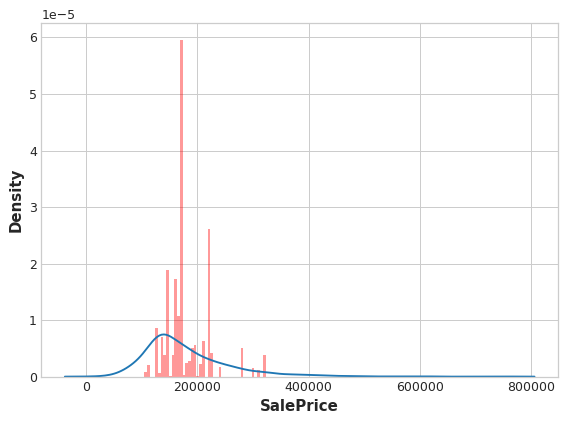

In [17]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

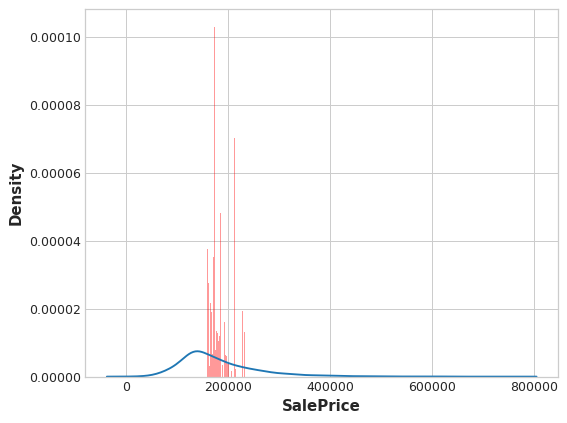

In [30]:
# my
feature = encoder_2.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train_2[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

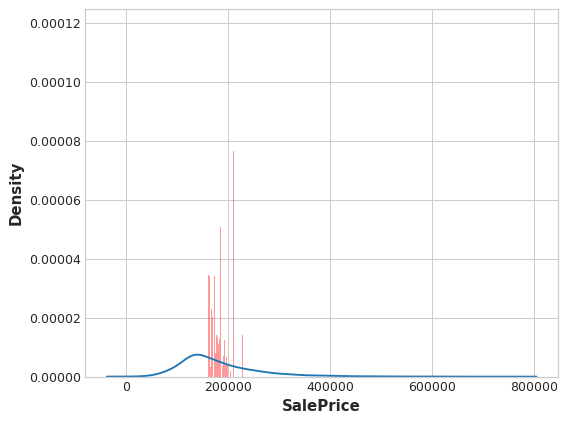

In [43]:
feature = encoder_2.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train_2[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

From the distribution plots, does it seem like the encoding is informative?

And this cell will show you the score of the encoded set compared to the original set:

In [19]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1431 RMSLE
Score with Encoding: 0.1421 RMSLE


In [44]:
# My
score_new_2 = score_dataset(X_train_2, y_train)
print(f"Score with Encoding: {score_new_2:.4f} RMSLE")

# Tests with m = 0.2, and cols= ["Neighborhood", "SaleType","MSSubClass", "Exterior1st", "Exterior2nd"] 
# Score was  0.1431 RMSLE
# Tests with m = 25, and cols= ["Neighborhood", "SaleType","MSSubClass", "Exterior1st", "Exterior2nd"] 
# Score was  0.1422 RMSLE
# Tests with m = 65, and cols= ["Neighborhood", "SaleType","MSSubClass", "Exterior1st", "Exterior2nd"] 
# Score was  0.1407 RMSLE
# Tests with m = 186, and cols= ["Neighborhood", "SaleType","MSSubClass", "Exterior1st", "Exterior2nd"] 
# Score was  0.1408 RMSLE
# Tests with m = 108, and cols= ["Neighborhood", "SaleType","MSSubClass", "Exterior1st", "Exterior2nd"] 
# Score was  0.1424 RMSLE
# Tests with m = 88, and cols= ["Neighborhood", "SaleType","MSSubClass", "Exterior1st", "Exterior2nd"] 
# Score was  0.1410 RMSLE
# Last test  m = 72

Score with Encoding: 0.1406 RMSLE


Do you think that target encoding was worthwhile in this case? Depending on which feature or features you chose, you may have ended up with a score significantly worse than the baseline. In that case, it's likely the extra information gained by the encoding couldn't make up for the loss of data used for the encoding.

*Смятате ли, че целевото кодиране си е струвало в този случай? В зависимост от характеристиката или характеристиките, които сте избрали, може да сте получили значително по-лош резултат от базовия. В този случай е вероятно допълнителната информация, получена от кодирането, да не може да компенсира загубата на данни, използвани за кодирането.*

-------------------------------------------------------------------------------

In this question, you'll explore the problem of overfitting with target encodings. This will illustrate this importance of training fitting target encoders on data held-out from the training set.

*Сега ще изследваме проблема със свръхнастройването(overfitting) с целеви кодировки. Това ще илюстрира важността на обучението за монтиране(подаване) на целевите енкодери върху данни, задържани от набора за обучение.*

So let's see what happens when we fit the encoder and the model on the *same* dataset. To emphasize how dramatic the overfitting can be, we'll mean-encode a feature that should have no relationship with `SalePrice`, a count: `0, 1, 2, 3, 4, 5, ...`.

*
Така че нека да видим какво се случва, когато съберем енкодера и модела върху *същия* набор от данни. За да подчертаем колко драматично може да бъде пренастройването, ще имаме предвид-кодираме функция, която не трябва да има връзка с „SalePrice“, брой: „0, 1, 2, 3, 4, 5, ...“.*

In [45]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 0

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent(заобикали) error-checking in MEstimateEncoder

# def my_test_results(): 
for i in [0, 1, 5, 50]:
        # fit and transform on the same dataset
        encoder = MEstimateEncoder(cols="Count", m = i)
        X = encoder.fit_transform(X, y)

    # Results
        score =  score_dataset(X, y)
        print(f"Score for m = {i}: {score:.4f} RMSLE")

# Score for m = 0: 0.0294 RMSLE
# Score for m = 1: 0.0849 RMSLE
# Score for m = 5: 0.1126 RMSLE
# Score for m = 50: 0.1165 RMSLE
        

Score for m = 0: 0.0294 RMSLE
Score for m = 1: 0.0849 RMSLE
Score for m = 5: 0.1126 RMSLE
Score for m = 50: 0.1165 RMSLE


In [51]:
# My

'''X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split(subset)
X_pretrain = df.drop(X_encode.index)
print(f"X_pretrain.shape before .pop(): {X_pretrain.shape}")
y_train = X_pretrain.pop("SalePrice")
'''
# ---------
# Encoding split(subset)
X_1 = df.sample(frac=0.20, random_state=0)
y_1 = X_1.pop('SalePrice')

# Training split(subset)
X_2 = df.drop(X_1.index)
y_2 = X_2.pop("SalePrice")


# Create an uninformative feature
X_1["Count"] = range(len(X_1))
X_1["Count"][1] = 0  # actually need one duplicate value to circumvent(заобикали) error-checking in MEstimateEncoder

# def my_test_results(): 
for m in [0, 1, 5, 50]:
        # fit and transform on the same dataset
        encoder = MEstimateEncoder(cols="Count", m=m)
        X_3 = encoder.fit_transform(X_1, y_1)

    # Results
        score =  score_dataset(X_2, y_2)
        # score =  score_dataset(X_3, y_1)
        # Score for m = 0: 0.1609 RMSLE
        # Score for m = 1: 0.1609 RMSLE
        # Score for m = 5: 0.1609 RMSLE
        # Score for m = 50: 0.1609 RMSLE
        print(f"Score for m = {m}: {score:.4f} RMSLE")
        
# result is worse as expected       

Score for m = 0: 0.1463 RMSLE
Score for m = 1: 0.1463 RMSLE
Score for m = 5: 0.1463 RMSLE
Score for m = 50: 0.1463 RMSLE


In [50]:
# My
X["Count"]

0       173864.040046
1       173864.040046
2       179853.625061
3       185477.833397
4       180974.568694
            ...      
2925    176692.910775
2926    172496.716724
2927    170121.921928
2928    177711.471477
2929    181894.966160
Name: Count, Length: 2930, dtype: float64

Almost a perfect score!

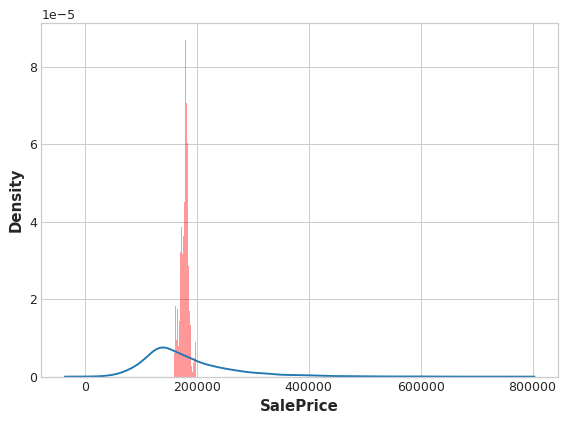

In [53]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

And the distributions are almost exactly the same, too.

 - Score for m = 0: 0.0294 RMSLE
 - Score for m = 1: 0.0849 RMSLE
 - .....

# 3) Overfitting with Target Encoders

Based on your understanding of how mean-encoding works, can you explain how XGBoost was able to get an almost a perfect fit after mean-encoding the count feature?

In [ ]:
# View the solution (Run this cell to receive credit!)
q_3.check()

*Тъй като "Count" никога няма дублирани стойности, средно кодираният "Count" е по същество точно копие на целта. С други думи, средното кодиране превърна една напълно безсмислена функция в перфектна характеристика.

Единствената причина, поради която това проработи, е, че обучихме XGBoost на същия комплект, който използвахме за обучение на енкодера. Ако вместо това бяхме използвали набор за задържане, нищо от това „фалшиво“ кодиране нямаше да се прехвърли към данните за обучение.

Урокът е, че когато използвате целеви енкодер, е много важно да използвате отделни набори от данни за обучение на енкодера и обучение на модела. В противен случай резултатите могат да бъдат много разочароващи!*

In [ ]:
# Uncomment this if you'd like a hint before seeing the answer
#q_3.hint()

# The End #

That's it for *Feature Engineering*! We hope you enjoyed your time with us.

Now, are you ready to try out your new skills? Now would be a great time to join our [Housing Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) Getting Started competition. We've even prepared a [Bonus Lesson](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices) that collects all the work we've done together into a starter notebook.

# References #
Here are some great resources you might like to consult for more information. They all played a part in shaping this course:
- *The Art of Feature Engineering*, a book by Pablo Duboue.
- *An Empirical Analysis of Feature Engineering for Predictive Modeling*, an article by Jeff Heaton.
- *Feature Engineering for Machine Learning*, a book by Alice Zheng and Amanda Casari. The tutorial on clustering was inspired by this excellent book.
- *Feature Engineering and Selection*, a book by Max Kuhn and Kjell Johnson.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*